## Train and restore with trivial conv net

This example attempts to train a trivial convolutional neural network to restore a blurred and noisy image. 

The example is not expected to produce good results as currently written as the receptive field of the network is small (there are not pooling layers).  The main purpose of the example is simply to show that a 'shallow' network cannot procuce good results.  

In the future the example may be improved to demonstrate how adding pooling layers (or other strategies) to increase the receptive field improves the performance.

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
from skimage.io import imread

## Get list of devices

In this step you want to confirm there is a GPU available

In [2]:
# Get the list of visible devices
visible_devices = tf.config.list_physical_devices()

print(visible_devices)

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Set network architecture

In this case the network is 3, 3D conv-nets but no pooling.  We don't expect this type of network to perform too well. 


In [3]:

# Set random seed for reproducibility
tf.random.set_seed(52)

# Define the CNN architecture
def create_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv3D(4, (7, 7, 7), padding='same', activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.Conv3D(4, (7, 7, 7), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv3D(1, (7, 7, 7), padding='same'))
    return model

# Define the loss function
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

c:\Users\bnort\miniconda3\envs\dresden-decon-test1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Load the corrupted images and ground truth images

... add a trivial channel, normalize the intensities and form an array of training images

In [6]:
corrupted_dir = r"D:\images\deep-learning\small_spheres\train\images"
ground_truth_dir = r"D:\images\deep-learning\small_spheres\train\ground truth"
corrupted_files = os.listdir(corrupted_dir)
ground_truth_files = os.listdir(ground_truth_dir)

# Preprocess the images
X_train = []
Y_train = []
for i in range(len(corrupted_files)):
    # Load the corrupted image and ground truth image
    corrupted_img = imread(os.path.join(corrupted_dir, corrupted_files[i]), plugin='tifffile')
    ground_truth_img = imread(os.path.join(ground_truth_dir, ground_truth_files[i]), plugin='tifffile')
    # Resize the images to the desired size
    #corrupted_img = np.reshape(corrupted_img, (256, 256, 100, 1))
    #ground_truth_img = np.reshape(ground_truth_img, (256, 256, 100, 1))
    
    # add trivial channels dimension
    corrupted_img = corrupted_img[..., np.newaxis]
    ground_truth_img = ground_truth_img[..., np.newaxis]

    print(corrupted_img.min(), corrupted_img.max())
    print(ground_truth_img.min(), ground_truth_img.max())
    # Normalize the pixel values to [0, 1]
    corrupted_img = (corrupted_img.astype('float32')-corrupted_img.min()) / (corrupted_img.max() - corrupted_img.min())
    ground_truth_img = (ground_truth_img.astype('float32')-ground_truth_img.min()) / (ground_truth_img.max() - ground_truth_img.min()) 
    # Append the preprocessed images to the training set
    X_train.append(corrupted_img)
    Y_train.append(ground_truth_img)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

3 601
0.0 6272.6396
5 579
0.0 6272.6396
3 474
0.0 6130.8896
4 593
0.0 6193.69
4 579
0.0 6115.2397
4 687
0.0 6304.36
3 570
0.0 6209.44
2 590
0.0 6336.1597
5 639
0.0 6256.81
2 448
0.0 6115.2397
3 626
0.0 6130.8896
5 668
0.0 6115.2397
7 583
0.0 6193.69
8 573
0.0 5944.4097
6 659
0.0 6225.21
4 548
0.0 6352.09
3 522
0.0 6400.0
5 527
0.0 5329.0
4 675
0.0 6162.25
6 545
0.0 6400.0


In [14]:
print(X_train.shape)

(20, 16, 128, 128, 1)


## Define and compile a model, perform training and save

In [7]:
# Define the input shape of the model
input_shape = X_train[0].shape

# Create the model
model = create_model(input_shape)

# Compile the model
model.compile(loss=mse_loss, optimizer=optimizer)

# Train the model
model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_split=0.2)

# Save the model
model.save('restoration_model.h5')

Epoch 1/5
1/1 [==============================] - 16s 16s/step - loss: 0.0152 - val_loss: 0.0125
Epoch 2/5
1/1 [==============================] - 1s 678ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 3/5
1/1 [==============================] - 1s 653ms/step - loss: 0.0119 - val_loss: 0.0108
Epoch 4/5
1/1 [==============================] - 1s 679ms/step - loss: 0.0105 - val_loss: 0.0118
Epoch 5/5
1/1 [==============================] - 1s 687ms/step - loss: 0.0114 - val_loss: 0.0098


## Try with more epochs

In [15]:

model.fit(X_train, Y_train, batch_size=16, epochs=150, steps_per_epoch=200, validation_split=0.2)

Epoch 1/150
 10/200 [>.............................] - ETA: 28:02 - loss: 0.0057

## Paste example result

(16, 128, 128, 1) 0.0 1.0
(16, 128, 128, 1) 0.0 1.0


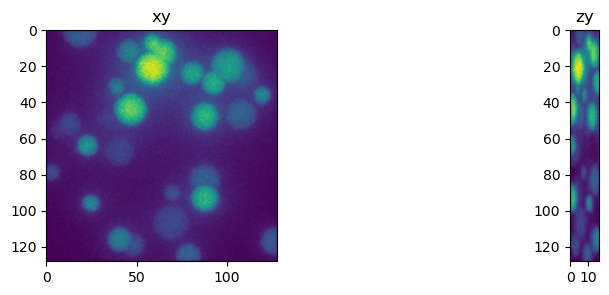

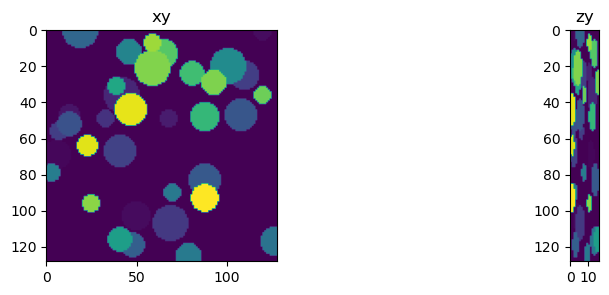

In [9]:
from tnia.plotting.projections import show_xy_zy_max

n=0

print(X_train[n].shape, X_train[n].min(), X_train[n].max())
fig = show_xy_zy_max(np.squeeze(X_train[[n]]))
print(Y_train[n].shape, Y_train[n].min(), Y_train[n].max())
fig = show_xy_zy_max(np.squeeze(Y_train[n]))

In [12]:
X_train[n].shape

(16, 128, 128, 1)

1/1 [==============================] - 1s 601ms/step
(1, 16, 128, 128, 1)


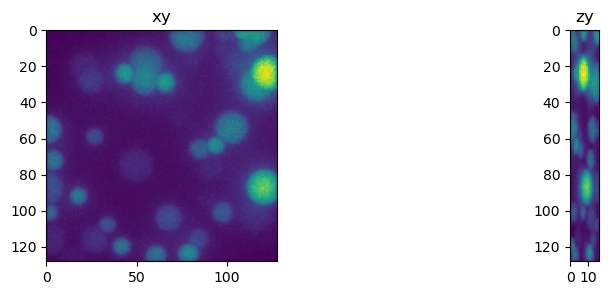

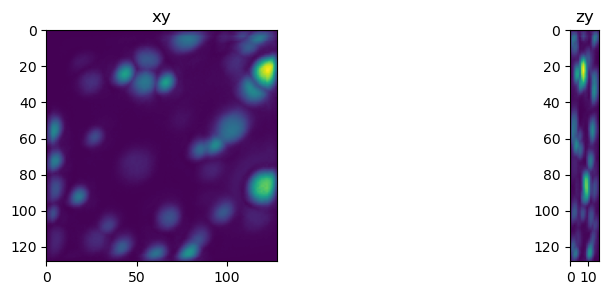

In [13]:
n=10

#output = model.predict(X_train[0])
input = X_train[n].reshape(1, 16, 128, 128, 1)
output = model.predict(input)
print(output.shape)
fig = show_xy_zy_max(np.squeeze(input))
fig = show_xy_zy_max(np.squeeze(output))

(86, 256, 256, 1) 0.0 1.0
-0.054212343 0.051616944


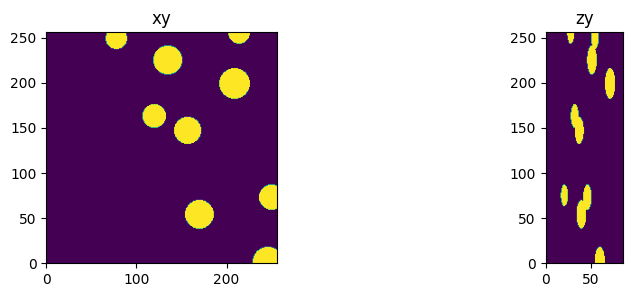

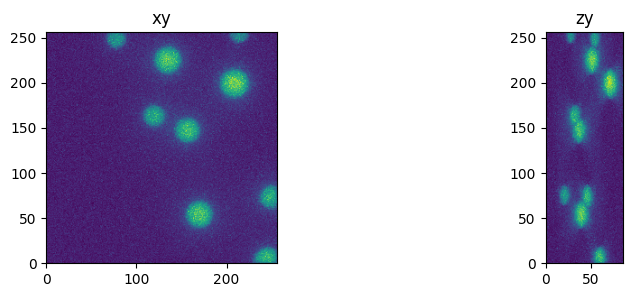

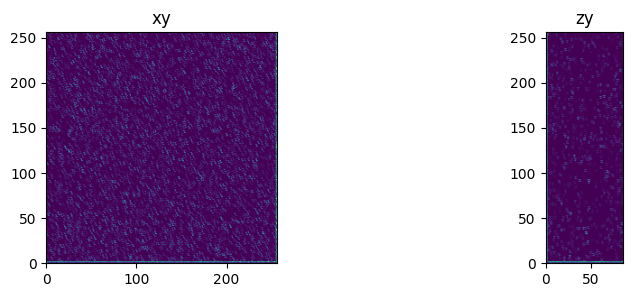

In [102]:
test=np.squeeze(output)
print(Y_train[n].shape, Y_train[n].min(), Y_train[n].max())
print(test.min(), test.max())
#test=test-test.min()
fig = show_xy_zy_max(Y_train[n])
fig = show_xy_zy_max(X_train[n])
fig = show_xy_zy_max(test)

In [55]:
test.min(), test.max()

(0.0, 0.39403412)

In [69]:
import napari
viewer = napari.Viewer()
viewer.add_image(np.squeeze(X_train[1]), name='corrupted')
viewer.add_image(np.squeeze(Y_train[1]), name='ground truth')
viewer.add_image(test, name='restored')

<Image layer 'restored' at 0x2af2f988f70>

In [20]:
X_train[0].shape

(86, 256, 256, 1)

In [21]:
test.shape

(1, 86, 256, 256, 3)

In [22]:
Y_train[0].shape

(86, 256, 256, 1)